<a href="https://colab.research.google.com/github/juhang-lee/AI_VISION/blob/juhang-lee-patch-1/5_day/3.openvino/3.handwritten_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OpenVINO™를 사용한 필기체 중국어 및 일본어 OCR

이 튜토리얼에서는 필기체 중국어(간체)와 일본어에 대해 광학 문자 인식(OCR)을 수행합니다. 라틴 알파벳을 사용한 OCR 튜토리얼은 [노트북 208](../208-optical-character-recognition/208-optical-character-recognition.ipynb)에서 확인할 수 있습니다. 이 모델은 한 번에 한 줄의 기호만 처리할 수 있습니다.

이 노트북에 사용된 모델은 [`handwriter-japanese-recognition-0001`](https://docs.openvino.ai/2023.0/omz_models_model_handwriter_japanese_recognition_0001.html) 및 [`handwriter-simplified-chinese-0001`](https: //docs.openvino.ai/2023.0/omz_models_model_handwriter_simplified_chinese_recognition_0001.html). 모델 출력을 읽을 수 있는 텍스트로 디코딩하려면 [`kondate_nakayosi`](https://github.com/openvinotoolkit/open_model_zoo/blob/master/data/dataset_classes/kondate_nakayosi.txt) 및 [`scut_ept`](https://github. com/openvinotoolkit/open_model_zoo/blob/master/data/dataset_classes/scut_ept.txt) 문자 목록이 사용됩니다. 두 모델 모두 [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/)에서 사용할 수 있습니다.

#### 내용의 테이블:
- [수입](#Imports-Uparrow)
- [설정](#설정-위쪽 화살표)
- [언어 선택](#Select-a-Language-Uparrow)
- [모델 다운로드](#Download-the-Model-Uparrow)
- [모델 로드 및 실행](#Load-the-Model-and-Execute-Uparrow)
- [추론 장치 선택](#Select-inference-device-Uparrow)
- [입력 및 출력 레이어에 대한 정보 가져오기](#Fetch-Information-About-Input-and-Output-Layers-Uparrow)
- [이미지 로드](#Load-an-Image-Uparrow)
- [입력 이미지 시각화](#Visualize-Input-Image-Uparrow)
- [Charlist 준비](#Prepare-Charlist-Uparrow)
- [추론 실행](#Run-Inference-Uparrow)
- [출력 데이터 처리](#Process-the-Output-Data-Uparrow)
- [출력물 인쇄](#Print-the-Output-Uparrow)

In [1]:
# Install openvino-dev package
%pip install -q "openvino>=2023.1.0"
%pip install -q matplotlib numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 12.9 MB/s eta 0:00:00


## Imports [$\Uparrow$](#Table-of-content:)


In [2]:
from collections import namedtuple
from itertools import groupby

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov

# Fetch `notebook_utils` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)
from notebook_utils import download_file

## 설정 [$\Uparrow$](#목차:)

이 노트북에 사용되는 모든 상수와 폴더를 설정하세요.

In [3]:
# Directories where data will be placed.
base_models_dir = "models"
data_folder = "data"
charlist_folder = f"{data_folder}/text"

# Precision used by the model.
precision = "FP16"

파일을 그룹화하려면 컬렉션을 정의해야 합니다. 이 경우 `namedtuple`을 사용하세요.

In [4]:
Language = namedtuple(
    typename="Language", field_names=["model_name", "charlist_name", "demo_image_name"]
)
chinese_files = Language(
    model_name="handwritten-simplified-chinese-recognition-0001",
    charlist_name="chinese_charlist.txt",
    demo_image_name="handwritten_chinese_test.jpg",
)
japanese_files = Language(
    model_name="handwritten-japanese-recognition-0001",
    charlist_name="japanese_charlist.txt",
    demo_image_name="handwritten_japanese_test.png",
)

## 언어 선택 [$\Uparrow$](#목차:)

선택 사항에 따라 아래 셀의 코드 줄을 변경해야 합니다.

일본어 텍스트에 대해 OCR을 수행하려면 `언어 = "일본어"`를 설정하세요. 중국어의 경우 `언어 = "중국어"`를 설정하세요.

In [5]:
# Select the language by using either language="chinese" or language="japanese".
language = "chinese"

languages = {"chinese": chinese_files, "japanese": japanese_files}

selected_language = languages.get(language)

## 모델 다운로드 [$\Uparrow$](#목차:)

이미지와 문자 목록 외에도 모델 파일을 다운로드해야 합니다. 아래 섹션에는 중국 또는 일본 모델을 다운로드하기 위한 셀이 있습니다.

노트북을 처음 실행하는 경우 모델이 다운로드됩니다. 몇 분 정도 걸릴 수 있습니다.

utils 패키지의 `download_file` 기능을 사용하면 자동으로 디렉토리 구조가 생성되고 선택한 모델 파일이 다운로드됩니다.

In [6]:
path_to_model = download_file(
    url=f'https://storage.openvinotoolkit.org/repositories/open_model_zoo/2023.0/models_bin/1/{selected_language.model_name}/{precision}/{selected_language.model_name}.xml',
    directory=base_models_dir
)
_ = download_file(
    url=f'https://storage.openvinotoolkit.org/repositories/open_model_zoo/2023.0/models_bin/1/{selected_language.model_name}/{precision}/{selected_language.model_name}.bin',
    directory=base_models_dir
)

models/handwritten-simplified-chinese-recognition-0001.xml:   0%|          | 0.00/108k [00:00<?, ?B/s]

models/handwritten-simplified-chinese-recognition-0001.bin:   0%|          | 0.00/32.9M [00:00<?, ?B/s]

## 모델 로드 및 실행 [$\Uparrow$](#목차:)

모든 파일이 다운로드되고 언어가 선택되면 네트워크를 읽고 컴파일하여 추론을 실행합니다. 모델 경로는 선택한 언어에 따라 정의됩니다.

In [7]:
core = ov.Core()
model = core.read_model(model=path_to_model)

## 추론 장치 선택 [$\Uparrow$](#목차:)

OpenVINO를 사용하여 추론을 실행하려면 드롭다운 목록에서 장치를 선택하세요.

In [8]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [10]:
compiled_model = core.compile_model(model=model, device_name=device.value)

## 입력 및 출력 레이어에 대한 정보 가져오기 [$\Uparrow$](#목차:)

이제 모델이 로드되었으므로 입력 및 출력 레이어(모양)에 대한 정보를 가져옵니다.

In [11]:
recognition_output_layer = compiled_model.output(0)
recognition_input_layer = compiled_model.input(0)

## 이미지 로드 [$\Uparrow$](#목차:)

다음으로 이미지를 로드합니다. 모델은 단일 채널 이미지를 입력으로 예상하므로 이미지는 회색조로 읽혀집니다.

입력 이미지를 로드한 후 필요한 입력 레이어 높이와 현재 이미지 높이 사이의 배율 비율을 계산하는 데 사용할 정보를 가져옵니다. 아래 셀에서는 글자의 비율을 유지하고 입력 모양에 맞게 이미지 크기가 조정되고 채워집니다.

In [12]:
# Download the image from the openvino_notebooks storage based on the selected model.
file_name = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/" + selected_language.demo_image_name,
    directory=data_folder
)

# Text detection models expect an image in grayscale format.
# IMPORTANT! This model enables reading only one line at time.

# Read the image.
image = cv2.imread(filename=str(file_name), flags=cv2.IMREAD_GRAYSCALE)

# Fetch the shape.
image_height, _ = image.shape

# B,C,H,W = batch size, number of channels, height, width.
_, _, H, W = recognition_input_layer.shape

# Calculate scale ratio between the input shape height and image height to resize the image.
scale_ratio = H / image_height

# Resize the image to expected input sizes.
resized_image = cv2.resize(
    image, None, fx=scale_ratio, fy=scale_ratio, interpolation=cv2.INTER_AREA
)

# Pad the image to match input size, without changing aspect ratio.
resized_image = np.pad(
    resized_image, ((0, 0), (0, W - resized_image.shape[1])), mode="edge"
)

# Reshape to network input shape.
input_image = resized_image[None, None, :, :]

data/handwritten_chinese_test.jpg:   0%|          | 0.00/42.1k [00:00<?, ?B/s]

## 입력 이미지 시각화 [$\Uparrow$](#목차:)

전처리 후 이미지를 표시할 수 있습니다.

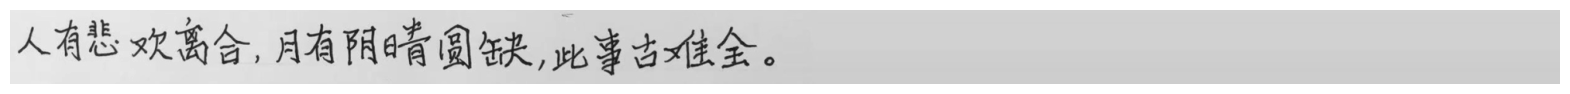

In [13]:
plt.figure(figsize=(20, 1))
plt.axis("off")
plt.imshow(resized_image, cmap="gray", vmin=0, vmax=255);

## Charlist 준비 [$\Uparrow$](#목차:)

모델이 로드되고 이미지가 준비되었습니다. 남은 유일한 요소는 다운로드되는 charlist입니다. 문자 목록을 사용하기 전에 문자 목록 시작 부분에 빈 기호를 추가해야 합니다. 이는 중국과 일본 모델 모두에서 예상됩니다.

In [14]:
# Download the image from the openvino_notebooks storage based on the selected model.
used_charlist_file = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/text/" + selected_language.charlist_name,
    directory=charlist_folder
)

data/text/chinese_charlist.txt:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

In [15]:
# Get a dictionary to encode the output, based on model documentation.
used_charlist = selected_language.charlist_name

# With both models, there should be blank symbol added at index 0 of each charlist.
blank_char = "~"

with used_charlist_file.open(mode="r", encoding="utf-8") as charlist:
    letters = blank_char + "".join(line.strip() for line in charlist)

## 추론 실행 [$\Uparrow$](#목차:)

이제 추론을 실행해 보세요. `compiled_model()` 함수는 모델 입력과 동일한 순서로 입력 목록을 가져옵니다. 그런 다음 출력 텐서에서 출력을 가져옵니다.

In [16]:
# Run inference on the model
predictions = compiled_model([input_image])[recognition_output_layer]

## 출력 데이터 처리 [$\Uparrow$](#목차:)

모델의 출력은 `W x B x L` 형식입니다. 여기서:

* W - 출력 시퀀스 길이
* B - 배치 크기
* L - Kondate 및 Nakayosi에서 지원되는 기호 전체에 대한 신뢰도 분포.

사람이 더 쉽게 읽을 수 있는 형식을 얻으려면 확률이 가장 높은 기호를 선택하세요. [CTC 디코딩](https://towardsdatascience.com/beam-search-decoding-in-ctc-trained-neural-networks-5a889a3d85a7)의 한계로 인해 가장 높은 확률을 가질 것으로 예측되는 인덱스 목록을 보유하는 경우 ), 동시 기호를 제거한 다음 공백을 제거합니다.

마지막으로 charlist의 해당 인덱스에서 기호를 가져옵니다.

In [17]:
# Remove a batch dimension.
predictions = np.squeeze(predictions)

# Run the `argmax` function to pick the symbols with the highest probability.
predictions_indexes = np.argmax(predictions, axis=1)

In [18]:
# Use the `groupby` function to remove concurrent letters, as required by CTC greedy decoding.
output_text_indexes = list(groupby(predictions_indexes))

# Remove grouper objects.
output_text_indexes, _ = np.transpose(output_text_indexes, (1, 0))

# Remove blank symbols.
output_text_indexes = output_text_indexes[output_text_indexes != 0]

# Assign letters to indexes from the output array.
output_text = [letters[letter_index] for letter_index in output_text_indexes]

## 출력 인쇄 [$\Uparrow$](#목차:)

이제 모델이 예측한 문자 목록이 있으므로 아래에 예측 텍스트가 인쇄된 이미지를 표시할 수 있습니다.

人有悲欢离合，月有阴睛圆缺，此事古难全。


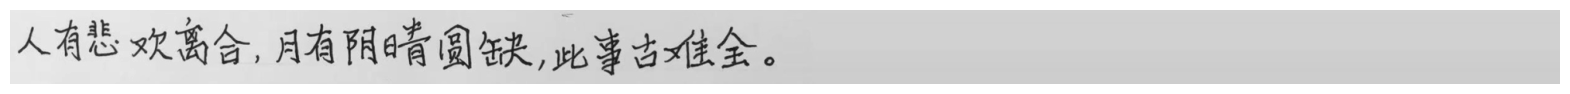

In [19]:
plt.figure(figsize=(20, 1))
plt.axis("off")
plt.imshow(resized_image, cmap="gray", vmin=0, vmax=255)

print("".join(output_text))